In [4]:
# Import modules
import pandas as pd
from zipfile import ZipFile
import gzip, collections, random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

path = 'encode/20210418_hg19_8416ex'
# path = 'encode/legacy'

# Prepare metadata
metadata = pd.read_csv(path+'/metadata.tsv', sep='\t')
metadata_ = metadata[['File accession', 'Biosample term name', 'Biosample type', 'File assembly', 'Experiment target']]
metadata_ = metadata_[metadata_['Biosample type']=='cell line']

In [1]:
# Extract PFM files for each TF
filepath = 'encode/HOCOMOCOv11_full_HUMAN_mono_jaspar_format.txt'
tf = []
with open(filepath) as fp:
    for cnt, line in enumerate(fp):
        if line.startswith('>'):
            op = open('pfm/'+line.split('.')[0][1:].split('_')[0]+'.pfm', 'w')
        else:
            op.write(line)

In [11]:
# Calculate TF for hich PFM are available
tfs = []
for file in os.listdir('pfm'):
    tfs.append(file.split('_')[0].split('.')[0])

exps = []
for row in range(len(metadata_)):
    exps.append(metadata_.loc[row]['Experiment target'].split('-')[0])

s = set(tfs)
print('Total TFs:', len(s))
print('Experiments:', len(tfs))
print('Common:', len(s.intersection(set(exps))))

Total TFs: 678
Experiments: 678
Common: 188


In [2]:
# # Unzip data
# if os.path.isdir('extracted_bed'):
#     print('Files present.')
# else:
#     for file_ in tqdm(os.listdir('data')):
#         #path_to_file_to_be_extracted
#         ip = 'data/'+file_
#         #output file to be filled
#         op = open("extracted_bed/"+file_.split('.')[0]+"1.bed","w")

#         with gzip.open(ip,"rb") as ip_byte:
#             op.write(ip_byte.read().decode("utf-8"))
#             op.close()

Files present.


In [8]:
# Filterbed files with coordinates with length > 300
bed_path = path+'/data'
means=[]
for file_ in tqdm(os.listdir(bed_path)):
    if file_.split('.')[0]+'.bed' in os.listdir(path+"/flitered_data_/"):
        pass
    else:
        # Unzip single file at a time to save memory
        op = open('.temp', 'w')
        with gzip.open(bed_path+'/'+file_, "rb") as ip_byte:
            op.write(ip_byte.read().decode("utf-8"))
            op.close()

        bed = pd.read_csv('.temp', sep='\t', header=None)
        filtered_bed = bed[abs(bed[1]-bed[2])<=300]    # threshold 300bp
        filtered_bed = filtered_bed[abs(filtered_bed[1]-filtered_bed[2])>=20]    # threshold 20bp
        filtered_bed.to_csv(path+"/flitered_data_/"+file_.split('.')[0]+".bed", sep="\t", index=False)
        os.remove('.temp')

100%|██████████| 8416/8416 [2:39:41<00:00,  1.14s/it]


In [3]:
# Filter duplicate tf-celline pairs
cellline_dict = collections.Counter(metadata_['Biosample term name'])
master_record = pd.DataFrame()
for line in tqdm(cellline_dict):
    #print(line, cellline_dict[i])
    df = metadata_[metadata_['Biosample term name']==line]
    tfs = collections.Counter(df['Experiment target'])
    for tf in tfs:
        df_ = df[df['Experiment target']==tf]
        #for acc_ in df_['File accession'].values:
        master_record = master_record.append(df_[df_['File accession']==random.choice(df_['File accession'].values)], ignore_index=True)
        #if acc_+'.bed' in os.listdir('extracted_bed'):
print()
print(master_record.shape)

100%|██████████| 79/79 [00:01<00:00, 41.32it/s]
(1368, 5)



In [6]:
# bed_path = path+'/data'
# means=[]
# for file_ in tqdm(os.listdir(bed_path)):
#     op = open('.temp', 'w')
#     # print(file_)s
#     with gzip.open(bed_path+'/'+file_, "rb") as ip_byte:
#         op.write(ip_byte.read().decode("utf-8"))
#         op.close()
#     bed = pd.read_csv('.temp', sep='\t', header=None)
#     peak_len = abs(bed[1].values-bed[2].values)
#     means.append(np.mean(peak_len))
#     os.remove('.temp')
# plt.hist(means, ins=30)
#     # print(peak_len)
#     # print(bed.head())

100%|██████████| 8416/8416 [32:32<00:00,  4.31it/s]
DescribeResult(nobs=8416, minmax=(1.0, 299.99900333665556), mean=195.5251941455921, variance=2345.7413456083036, skewness=-0.8699803554056046, kurtosis=3.3147032617867653)


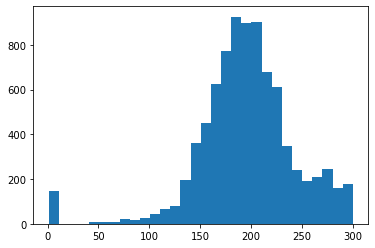

In [9]:
# Statistics for all the filtered bed files
means=[]
data_path = 'encode/20210418_hg19_8416ex/flitered_data_/'
# for acc in tqdm(master_record['File accession'].values):
for acc in tqdm(os.listdir(data_path)):
    data = pd.read_csv(data_path+acc, sep='\t', header=None)
    list_ = abs(data[1].values-data[2].values)
    means.append(np.mean(list_))

plt.hist(means, bins=30)
print(stats.describe(means))

100%|██████████| 1368/1368 [01:48<00:00, 12.60it/s]
DescribeResult(nobs=1368, minmax=(1.0, 299.9985866713778), mean=193.5583944110359, variance=2466.779963810169, skewness=-1.0979314306475914, kurtosis=3.7539749156099296)


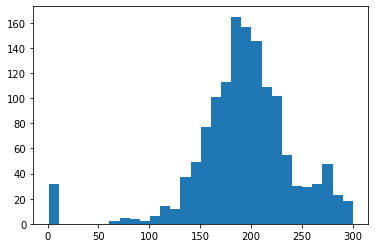

In [10]:
# For acceions in master_record
means=[]
for acc in tqdm(master_record['File accession'].values):
    try:
        data = pd.read_csv(data_path+acc+'.bed', sep='\t', header=None)
        list_ = abs(data[1].values-data[2].values)
        means.append(np.mean(list_))
    except:
        pass
        #print(acc)
    # print(means)
plt.hist(means, bins=30)
print(stats.describe(means))

In [9]:
means = []
for file_ in tqdm(os.listdir('encode/legacy/extracted_bed')):
    data = pd.read_csv('encode/legacy/extracted_bed/'+file_, sep='\t', header=None)
    list_ = abs(data[1].values-data[2].values)
    #print(stats.describe(list_))
    means.append(np.mean(list_))
    #plt.hist(list_, bins=20)s

fig, ax = plt.subplots(1, figsize=(7,5))
ax.hist(means, bins=30)
ax.set_xlabel('Mean sequence length', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
#ax.set_xticklabels(dates)
ax.grid(color='black', ls = '-.', lw = 0.25)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
print(stats.describe(means))

100%|██████████| 811/811 [04:44<00:00,  2.85it/s]


In [22]:
# Analyse MOODS output and fasta seqs
for file_ in os.listdir('encode/moods_out_'):
    coord = pd.read_csv('encode/moods_out_/'+file_, header = None)
    print(coord)
    break

                              0         1    2  3          4  \
0              chr1:91334-91551  CTCF.pfm   83  -   7.119328   
1              chr1:91334-91551  CTCF.pfm   85  +  11.381258   
2              chr1:91334-91551  CTCF.pfm   95  +   8.107524   
3            chr1:104934-105033  CTCF.pfm   50  -  11.330764   
4            chr1:237625-237890  CTCF.pfm  122  -   4.516742   
...                         ...       ...  ... ..        ...   
78627  chrX:155094407-155094600  CTCF.pfm   96  -   1.617767   
78628  chrX:155196611-155196868  CTCF.pfm   67  +   7.947954   
78629  chrX:155196611-155196868  CTCF.pfm  130  -   1.703055   
78630  chrX:155196611-155196868  CTCF.pfm  132  +   9.470827   
78631  chrX:155196611-155196868  CTCF.pfm  152  -   1.730784   

                         5   6  
0      GTGTGGCACCAGGTGGCAG NaN  
1      GTGGCACCAGGTGGCAGCA NaN  
2      GTGGCAGCAGAGGTCAGCA NaN  
3      ggctgccacctgctgttgg NaN  
4      GTGCAGCACCAGGTGGCAG NaN  
...                    ...  ..  


In [23]:
coord

,0,1,2,3,4,5,6
0,chr1:91334-91551,CTCF.pfm,83,-,7.119328,GTGTGGCACCAGGTGGCAG,NaN
1,chr1:91334-91551,CTCF.pfm,85,+,11.381258,GTGGCACCAGGTGGCAGCA,NaN
2,chr1:91334-91551,CTCF.pfm,95,+,8.107524,GTGGCAGCAGAGGTCAGCA,NaN
3,chr1:104934-105033,CTCF.pfm,50,-,11.330764,ggctgccacctgctgttgg,NaN
4,chr1:237625-237890,CTCF.pfm,122,-,4.516742,GTGCAGCACCAGGTGGCAG,NaN
...,...,...,...,...,...,...,...
78627,chrX:155094407-155094600,CTCF.pfm,96,-,1.617767,TTACTCCCCTTGGTGtcta,NaN
78628,chrX:155196611-155196868,CTCF.pfm,67,+,7.947954,GAGCCAAGAGGGGGCACAC,NaN
78629,chrX:155196611-155196868,CTCF.pfm,130,-,1.703055,GACAGCCACCAGATGGCAT,NaN
78630,chrX:155196611-155196868,CTCF.pfm,132,+,9.470827,CAGCCACCAGATGGCATGT,NaN


In [58]:
# from scipy.interpolate import make_interp_spline

# import datetime
# start = datetime.datetime.strptime("28-03-2021", "%d-%m-%Y")
# end = datetime.datetime.strptime("17-04-2021", "%d-%m-%Y")
# date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

# times = [49, 78, 51, 75, 50, 57, 34, 20, 17, 23, 39, 15, 10, 0, 21, 39, 26, 33, 60, 19]
# times_=list(reversed(times))
# times_

# dates = []
# for date in date_generated:
#     dates.append(date.strftime("%d-%m-%Y"))

# X_Y_Spline = make_interp_spline(np.linspace(0,19,20), times_)
# X_ = np.linspace(np.linspace(0,19,20).min(), np.linspace(0,19,20).max(), 500)
# Y_ = X_Y_Spline(X_)

# fig, ax = plt.subplots(1, figsize=(9,5))
# ax.plot(dates, times_, marker='o', color='r')
# ax.set_xlabel('Date', fontsize=14, fontweight='bold')
# ax.set_ylabel('Time on call (min)', fontsize=14, fontweight='bold')
# ax.set_xticklabels(dates)

# # # # We change the fontsize of minor ticks label 
# ax.tick_params(axis='x', which='major', labelsize=12, rotation=60)
# ax.tick_params(axis='y', which='major', labelsize=12)
# ax.grid(color='b', ls = '-.', lw = 0.25)

# ax.set_title('Phone record analysis (20 days)', fontsize=14, fontweight='bold')
# plt.savefig('phonecall.jpg', dpi=600, transparent=False, optimize=True,bbox_inches='tight')